# Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions



## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments in previous weeks. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be maximized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake model exercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in previous assignments had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100). Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a more advanced way of deciding on the amout of anhtropogenic polution. We will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following [Quinn et al. 2017](http://www.sciencedirect.com/science/article/pii/S1364815216302250) and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

**To formulate this problem, do the following:**

**1) Import the lake model function from dps_lake_model.py**

**2) Create an ema_workbench interface for this problem, with corresponding uncertainties, levers and outcomes as specified above**



In [1]:
from dps_lake_model import (lake_model, get_antropogenic_release)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging)

from ema_workbench import save_results, load_results

import os

#instantiate the model
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100
#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2),
                     RealParameter("w1", 0, 1)
                     ]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]


## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

Take the model interface developed in the previous step and use the optimization functionality of the workbench to identify the pareto approximate set of solutions. Try the following:
* change the epsilon values between 0.01 and 0.1, what changes, why?
* change the number of function evaluations from 1000 to 10.000 (this requires using multiprocessing unless you are very patient). What is the difference? You can use  convergence as explained in assignment 7 for this

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [115]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_1000_01 = evaluator.optimize(nfe=1000, epsilons=[0.1, 0.1, 0.1, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 492/1000 nfe
[MainProcess/INFO] generation 10: 987/1000 nfe
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


In [4]:
# with MultiprocessingEvaluator(lake_model) as evaluator:
#     results_1000_001 = evaluator.optimize(nfe=1000, epsilons=[0.01, 0.01, 0.01, 0.01, 0.01])

With a lower value for epsilon more solutions will be found as there are more cells in the grid of the objectives.

In [5]:
# with MultiprocessingEvaluator(lake_model) as evaluator:
#     results_10000_01 = evaluator.optimize(nfe=10000, epsilons=[0.1, 0.1, 0.1, 0.1, 0.1])

In [150]:
fn = "1000scenarios.tar.gz"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_10000_001 = pd.read_csv("results_10000_01.csv")
except IOError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        results_10000_001 = evaluator.optimize(nfe=10000, epsilons=[0.01, 0.01, 0.01, 0.01, 0.01])
    results_10000_001.to_csv("results_10000_01.csv")

nfe is the number of function evaluations, with a higher number of nfe the optimization function is more likely to converge

**plot the tradeoffs you have found using a parallel axis plot**

We can visualize these tradeoffs on **parallel axis plots**. In these plots, each dimension is shown as a vertical axis. Each solution is represented by a line on this plot, which crosses the objective axes at the corresponsing value. You can use the [parcoords functionality](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html) for this that comes with the ema_workbench. Ensure that the direction of desirability is the same for the four objectives.|



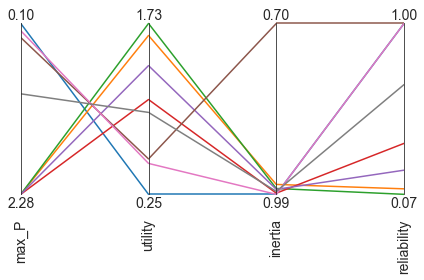

In [117]:
from ema_workbench.analysis import parcoords

# Lowest number of outcomes
outcomes_1000_01 = results_1000_01.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits_1000_01 = parcoords.get_limits(outcomes_1000_01)
axes = parcoords.ParallelAxes(limits_1000_01)
axes.plot(outcomes_1000_01)

# invert axes so direction of desirability is the same 
axes.invert_axis('max_P')
plt.show()


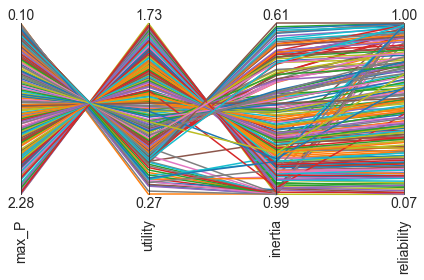

In [119]:
from ema_workbench.analysis import parcoords

# Highest number of outcomes
outcomes_10000_001 = results_10000_001.loc[:, ['max_P', 'utility', 'inertia', 'reliability']]

limits_10000_001 = parcoords.get_limits(outcomes_10000_001)
axes = parcoords.ParallelAxes(limits_10000_001)
axes.plot(outcomes_10000_001)

# invert axes so direction of desirability is the same  
axes.invert_axis('max_P') 
axes.invert_axis('inertia')
plt.show()


**What does this plot tell us about the tradeoffs and conflicting objectives?**

One line represent one solution and its outcome values. Here we can see how the tradeoffs between objectives are made per solution,

## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_results**


In [120]:
new_results = results_10000_001[results_10000_001["reliability"] > 0.90]
new_results

,Unnamed: 0,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0,0.125158,0.272257,0.701874,0.231414,0.944503,0.119469,0.344260,0.9900,1.0000
1,1,0.358035,0.340288,1.210285,0.465176,0.687931,0.157947,0.453744,0.9900,1.0000
2,2,0.696289,0.224407,1.672452,0.119295,0.944503,0.198996,0.525627,0.9900,1.0000
3,3,0.235446,0.237955,1.206646,0.246606,0.705658,0.139187,0.406702,0.9900,1.0000
5,5,0.251805,0.261812,1.877412,0.109876,0.415982,0.263747,0.550218,0.8729,1.0000
6,6,0.190992,0.155732,1.635064,0.081873,0.340987,0.158627,0.388644,0.9512,1.0000
7,7,0.834928,0.272257,1.765531,0.187653,0.405399,0.225499,0.551010,0.9900,1.0000
9,9,0.637169,0.265802,1.477314,0.124382,0.944503,0.214627,0.542952,0.9900,1.0000
12,12,-0.201420,0.272257,1.979107,0.091259,0.346416,0.278013,0.557132,0.6145,1.0000
13,13,0.372303,0.252480,1.739476,0.081873,0.341295,0.394995,0.640730,0.7198,0.9273



**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a format that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

In [121]:
new_results.columns

Index(['Unnamed: 0', 'c1', 'c2', 'r1', 'r2', 'w1', 'max_P', 'utility',
       'inertia', 'reliability'],
      dtype='object')

In [122]:
new_results = new_results[['c1', 'c2', 'r1', 'r2', 'w1']]
new_results

,c1,c2,r1,r2,w1
0,0.125158,0.272257,0.701874,0.231414,0.944503
1,0.358035,0.340288,1.210285,0.465176,0.687931
2,0.696289,0.224407,1.672452,0.119295,0.944503
3,0.235446,0.237955,1.206646,0.246606,0.705658
5,0.251805,0.261812,1.877412,0.109876,0.415982
6,0.190992,0.155732,1.635064,0.081873,0.340987
7,0.834928,0.272257,1.765531,0.187653,0.405399
9,0.637169,0.265802,1.477314,0.124382,0.944503
12,-0.201420,0.272257,1.979107,0.091259,0.346416
13,0.372303,0.252480,1.739476,0.081873,0.341295


In [220]:
policy_values = new_results.to_dict(orient='records')

In [221]:
from ema_workbench import Policy

policies = []
for i in range(len(policy_values)):
    policies.append(Policy(str(i), **policy_values[i]))

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyparallel, don't forget to start ipcluster.

In [222]:
from ema_workbench import perform_experiments

In [55]:
import os

fn = "1000scenarios.tar.gz"

try:
    # Only run the experiments again if data hasn't been generated yet
    results = load_results(fn)
except IOError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=1000, policies=policies)
    save_results(results, fn)

[MainProcess/INFO] results loaded succesfully from C:\Users\hp\Documents\EPA\Q4 2021\EPA1361\MBDM\Week 5-6 - robustness and direct search\1000scenarios.tar.gz


In [56]:
results[0].dtypes

b            float64
delta        float64
mean         float64
q            float64
stdev        float64
c1           float64
c2           float64
r1           float64
r2           float64
w1           float64
scenario    category
policy      category
model       category
dtype: object

In [57]:
experiments, outcomes = results

We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow uncertaintiy range. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation is different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel axis plot. Which solutions look like a good compromise policy?**

In [58]:
experiments.dtypes

b            float64
delta        float64
mean         float64
q            float64
stdev        float64
c1           float64
c2           float64
r1           float64
r2           float64
w1           float64
scenario    category
policy      category
model       category
dtype: object

In [59]:
experiments

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.217522,0.958420,0.012072,4.262556,0.004116,0.125158,0.272257,0.701874,0.231414,0.944503,0,Policy 0,lakeproblem
1,0.111334,0.939417,0.017873,3.656658,0.001200,0.125158,0.272257,0.701874,0.231414,0.944503,1,Policy 0,lakeproblem
2,0.371184,0.976577,0.033768,4.167496,0.004392,0.125158,0.272257,0.701874,0.231414,0.944503,2,Policy 0,lakeproblem
3,0.261868,0.939301,0.045751,3.476083,0.003460,0.125158,0.272257,0.701874,0.231414,0.944503,3,Policy 0,lakeproblem
4,0.273515,0.977410,0.045615,3.786011,0.001710,0.125158,0.272257,0.701874,0.231414,0.944503,4,Policy 0,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51995,0.219004,0.982656,0.021220,2.274399,0.002325,-0.013216,0.241165,1.658826,0.077515,0.346776,995,Policy 51,lakeproblem
51996,0.444259,0.976385,0.045363,2.016115,0.004410,-0.013216,0.241165,1.658826,0.077515,0.346776,996,Policy 51,lakeproblem
51997,0.334528,0.935413,0.026453,2.909931,0.004816,-0.013216,0.241165,1.658826,0.077515,0.346776,997,Policy 51,lakeproblem
51998,0.231818,0.960405,0.035388,4.284113,0.004892,-0.013216,0.241165,1.658826,0.077515,0.346776,998,Policy 51,lakeproblem


In [60]:
experiments.columns

Index(['b', 'delta', 'mean', 'q', 'stdev', 'c1', 'c2', 'r1', 'r2', 'w1',
       'scenario', 'policy', 'model'],
      dtype='object')

In [61]:
outcomes

{'max_P': array([ 0.1250448 , 10.03602036,  0.1297733 , ...,  2.3379468 ,
         0.23940033,  0.24546862]),
 'utility': array([0.20827469, 0.24659958, 0.27571176, ..., 0.346841  , 0.2408358 ,
        0.46428678]),
 'inertia': array([0.99  , 0.9734, 0.99  , ..., 0.7925, 0.946 , 0.5178]),
 'reliability': array([1.    , 0.2761, 1.    , ..., 0.643 , 1.    , 1.    ])}

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

We now have an understanding of which solutions have decent robustness using 2 different robustness metrics. A related but different question is to assess the uncertain conditions under which we get poor performance. For this, we can use scenario discovery. Since we want to identify the uncertainties only, we can remove the policy column from the experiments DataFrame. 

**Perform Scenario Discovery, focussed on understanding the conditions under which utility is lower than 0.25**

from the trade off curve between coverage, density and number of restricted dimensions, select a point which balances them. Next, using the `yi` attribute, select from the experiments data frame the rows which are within the box as well as the outcomes associated with these experiments.Save these results. They are the starting point for the next assignment. In pseudo code:

```python
from ema_workbench import save_results

selected_experiments = experiments.iloc[box.yi]
selected_outcomes = {k:v[box.yi] for k,v in outcomes.items()}

save_results((selected_experiments, selected_outcomes), './results/selected_results.tar.gz')
```





In [62]:
from ema_workbench.analysis import prim

# PCA Prim
With the PCA preprocess higher density and coverage boxes were found, thus we chose to use PCA

[MainProcess/INFO] 52000 points remaining, containing 7930 cases of interest
[MainProcess/INFO] mean: 0.8902714932126696, mass: 0.051, coverage: 0.29773013871374526, density: 0.8902714932126696 restricted_dimensions: 8


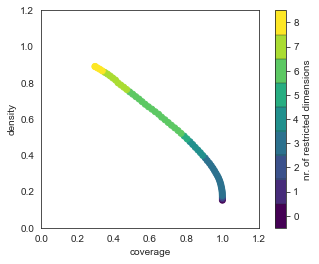

In [65]:
x = experiments
y = outcomes['utility'] < 0.25
to_exclude =['model', 'policy']

experiments['scenario'] = experiments['scenario'].astype(int)

# PCA
rotated_experiments, rotation_matrix = prim.pca_preprocess(x, y, exclude=to_exclude)

# Show PCA-PRIM results
PCA_prim_obj = prim.Prim(rotated_experiments, y, threshold=0.1)
box = PCA_prim_obj.find_box()

box.show_tradeoff()
plt.show()

In [66]:
box.peeling_trajectory[30:]

,coverage,density,id,mass,mean,res_dim
30,0.754981,0.536758,30,0.214500,0.536758,6
31,0.736948,0.551529,31,0.203769,0.551529,6
32,0.718537,0.566064,32,0.193577,0.566064,6
33,0.700757,0.581155,33,0.183885,0.581155,6
34,0.682976,0.596279,34,0.174673,0.596279,6
35,0.664439,0.610686,35,0.165923,0.610686,6
36,0.647919,0.626891,36,0.157615,0.626891,6
37,0.629004,0.640637,37,0.149731,0.640637,6
38,0.610719,0.654813,38,0.142231,0.654813,6
39,0.591803,0.667948,39,0.135115,0.667948,6


In [67]:
box.inspect(44)

coverage    0.505296
density     0.737394
id                44
mass          0.1045
mean        0.737394
res_dim            6
Name: 44, dtype: object

        box 44                                           
           min       max                        qp values
r_8  -2.648449  0.154973  [-1.0, 1.9250189260523422e-243]
r_7  -2.933232  0.506598    [-1.0, 2.949326790910003e-21]
r_2  -3.645776  1.621438   [-1.0, 1.5930231254155903e-09]
r_9  -2.117315  0.678379     [-1.0, 0.054491319564677954]
r_10 -0.654876  0.139763    [7.719937965099733e-294, 0.0]
r_6  -1.460036  3.185532   [1.0821205533433125e-07, -1.0]



In [68]:
box.select(44)

selected_experiments = experiments.iloc[box.yi]
selected_outcomes = {k:v[box.yi] for k,v in outcomes.items()}

In [69]:
# For some reason the dtypes of these columns raise an error when loading back up, so change them to object
selected_experiments["policy"] = selected_experiments["policy"].astype(str)
selected_experiments["model"] = selected_experiments["model"].astype(str)

C:\Users\hp\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hp\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
selected_experiments.dtypes

b           float64
delta       float64
mean        float64
q           float64
stdev       float64
c1          float64
c2          float64
r1          float64
r2          float64
w1          float64
scenario      int32
policy       object
model        object
dtype: object

In [71]:
selected_outcomes

{'max_P': array([0.21442301, 0.1960995 , 0.16405545, ..., 9.42978972, 6.1585791 ,
        0.37579898]),
 'utility': array([0.22863154, 0.20349124, 0.18755998, ..., 0.51439835, 0.3148187 ,
        0.23513505]),
 'inertia': array([0.99  , 0.99  , 0.99  , ..., 0.9736, 0.9753, 0.9848]),
 'reliability': array([1.    , 1.    , 1.    , ..., 0.1022, 0.2211, 0.9647])}

In [72]:
save_results((selected_experiments, selected_outcomes), './results/selected_results.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\hp\Documents\EPA\Q4 2021\EPA1361\MBDM\Week 5-6 - robustness and direct search\results\selected_results.tar.gz


In [73]:
load_results('./results/selected_results.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\hp\Documents\EPA\Q4 2021\EPA1361\MBDM\Week 5-6 - robustness and direct search\results\selected_results.tar.gz


(             b     delta      mean         q     stdev        c1        c2  \
 0     0.273515  0.977410  0.045615  3.786011  0.001710  0.125158  0.272257   
 1     0.247986  0.971721  0.037351  4.209994  0.004012  0.125158  0.272257   
 2     0.133090  0.965256  0.010909  4.053383  0.003768  0.125158  0.272257   
 3     0.204798  0.972639  0.032819  3.917798  0.003090  0.125158  0.272257   
 4     0.366422  0.931671  0.036192  2.414730  0.001717  0.125158  0.272257   
 ...        ...       ...       ...       ...       ...       ...       ...   
 5429  0.131182  0.947625  0.013143  4.179405  0.001012 -0.013216  0.241165   
 5430  0.108070  0.934070  0.016255  3.323201  0.002825 -0.013216  0.241165   
 5431  0.119168  0.938522  0.023876  4.092952  0.002137 -0.013216  0.241165   
 5432  0.184394  0.932155  0.035866  4.491360  0.001152 -0.013216  0.241165   
 5433  0.286991  0.955982  0.049906  4.255987  0.003639 -0.013216  0.241165   
 
             r1        r2        w1  scenario     